In [41]:
import numpy as np
from models.vgae import VariationalEncoder, L1VGAE
import torch
from utils.dataset import split_dataset

np.random.seed(1)
torch.manual_seed(1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_train, data_test, data_val, = split_dataset(True)

in_channels, out_channels, lr, n_epochs = data_train[0].num_features, 20, 0.001, 300


vae_layers, alpha, threshold = 2, 1.0, 0.65
vae = L1VGAE(VariationalEncoder(in_channels, out_channels, layers=vae_layers, molecular=True, transform=True), device)
vae.load_state_dict(torch.load(
    '../results/model_GCN/graph_split_/layers_' + str(
        vae_layers) + '/transform_'+str(True)+'/alpha_' + str(
        alpha) +'/model.pt'))

<All keys matched successfully>

In [42]:
from zinc_classifier import transform_zinc_dataset, transform_zinc_dataset_with_weights

train = transform_zinc_dataset_with_weights(vae, data_train, 0.75)
data_test = transform_zinc_dataset_with_weights(vae, data_test, 0.75)

In [43]:
data_train = train[0:10]
print(data_train)

[Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1], laplacian_eigenvector_pe=[29, 5], vr_edge_index=[2, 165], vr_edge_weight=[165]), Data(x=[26, 1], edge_index=[2, 56], edge_attr=[56], y=[1], laplacian_eigenvector_pe=[26, 5], vr_edge_index=[2, 166], vr_edge_weight=[166]), Data(x=[16, 1], edge_index=[2, 34], edge_attr=[34], y=[1], laplacian_eigenvector_pe=[16, 5], vr_edge_index=[2, 72], vr_edge_weight=[72]), Data(x=[27, 1], edge_index=[2, 60], edge_attr=[60], y=[1], laplacian_eigenvector_pe=[27, 5], vr_edge_index=[2, 181], vr_edge_weight=[181]), Data(x=[21, 1], edge_index=[2, 44], edge_attr=[44], y=[1], laplacian_eigenvector_pe=[21, 5], vr_edge_index=[2, 109], vr_edge_weight=[109]), Data(x=[28, 1], edge_index=[2, 60], edge_attr=[60], y=[1], laplacian_eigenvector_pe=[28, 5], vr_edge_index=[2, 188], vr_edge_weight=[188]), Data(x=[19, 1], edge_index=[2, 38], edge_attr=[38], y=[1], laplacian_eigenvector_pe=[19, 5], vr_edge_index=[2, 71], vr_edge_weight=[71]), Data(x=[16, 1], edge_in

In [49]:
def remove_repeating_edges(data):
    data_copy = []

    for graph in data:
        a = graph.edge_index.T
        b = graph.vr_edge_index.T
        value_b = graph.vr_edge_weight


        # get the common element
        # get the common element
        common = set(tuple(x.tolist()) for x in a) & set(tuple(x.tolist()) for x in b)

        # remove common element from b
        b = torch.stack([x for x in b if tuple(x.tolist()) not in common and x[0] != x[1]])



        a = torch.cat([a,b], dim=0)

        graph.new_edge_index = a.T

        data_copy.append(graph)

    return data_copy


def get_new_edge_index(data):
    new_data_list = []
    for graph in data:
        a = graph.edge_index.T
        b = graph.vr_edge_index.T
        value_b = graph.vr_edge_weight

        a_set = set(tuple(x.tolist()) for x in a)
        b_set = set(tuple(x.tolist()) for x in b)
        common = a_set & b_set

        b_filtered = torch.stack([x for x in b if tuple(x.tolist()) not in common and x[0] != x[1]])

        # get the indices of b_filtered in vr_edge_index
        b_indices = []
        for edge in b_filtered:
            index = (graph.vr_edge_index == edge).all(1).nonzero()
            b_indices.append(index)
        b_indices = torch.cat(b_indices).squeeze()

        # get the values corresponding to the indices of b_filtered
        value_b_filtered = value_b[b_indices]

        # sort b_filtered in descending order of values
        sorted_indices = torch.argsort(value_b_filtered, descending=True)
        b_filtered_sorted = b_filtered[sorted_indices]

        # concatenate a and b_filtered_sorted to create the new edge_index
        new_edge_index = torch.cat([a, b_filtered_sorted], dim=0)

        graph.new_edge_index = new_edge_index.T
        graph.new_edge_attr = torch.cat([graph.edge_attr, value_b_filtered[sorted_indices]], dim=0)


        new_data_list.append(graph)
    return new_data_list

data_train_x = get_new_edge_index(data_train)


RuntimeError: The size of tensor a (165) must match the size of tensor b (2) at non-singleton dimension 1

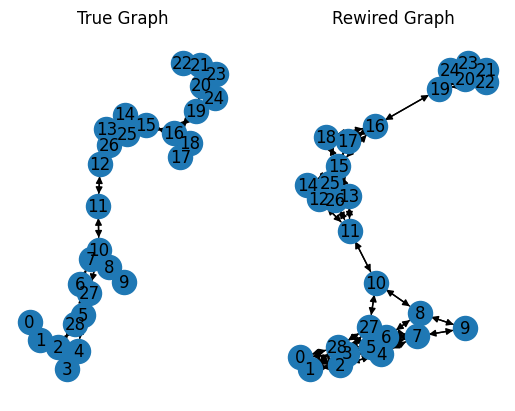

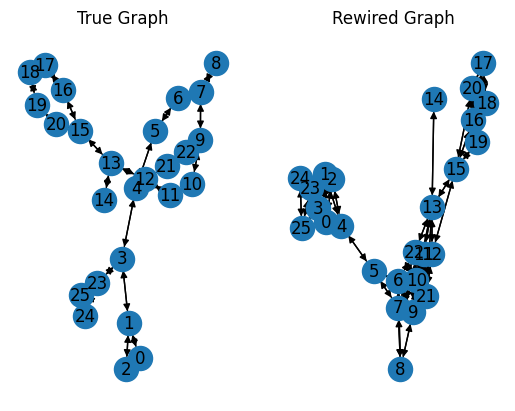

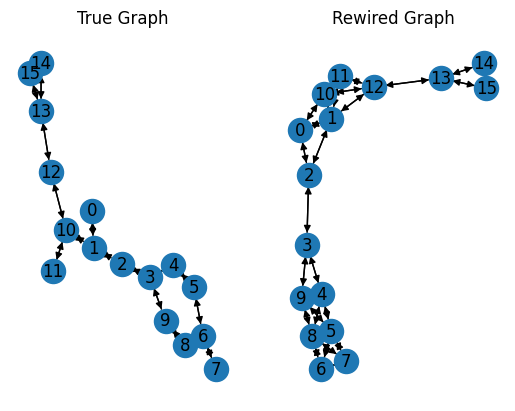

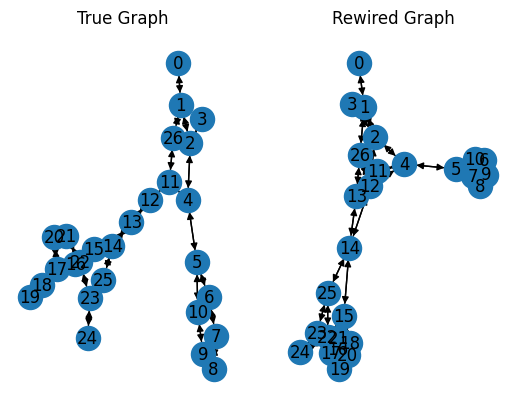

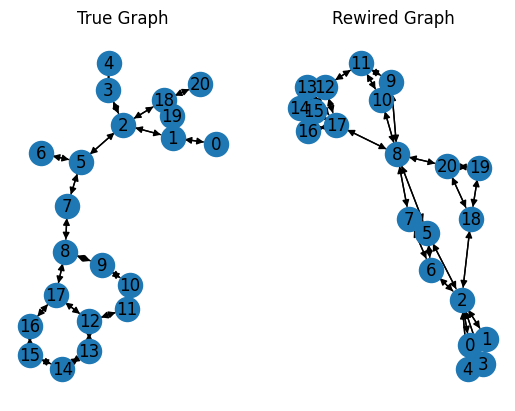

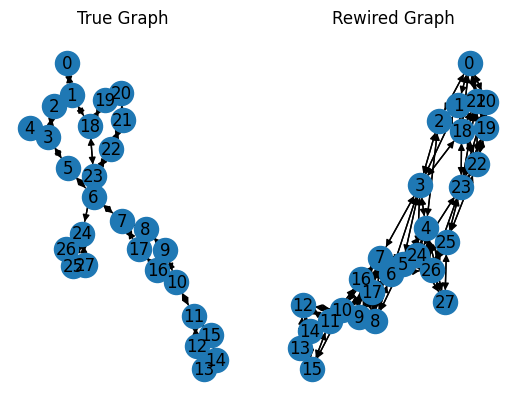

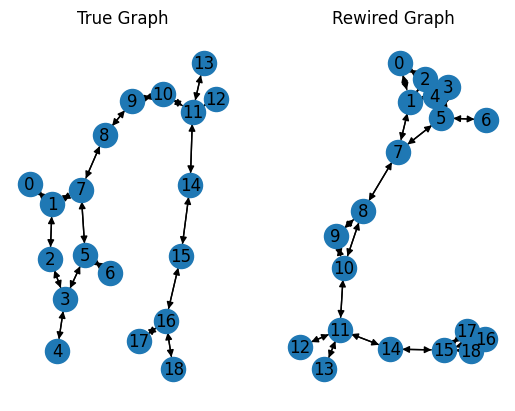

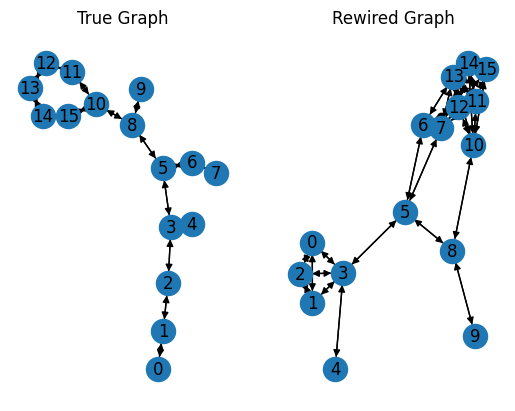

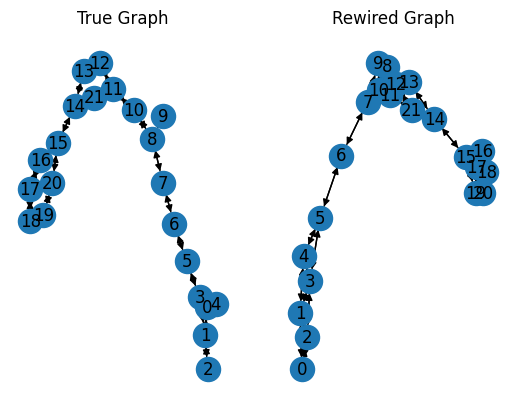

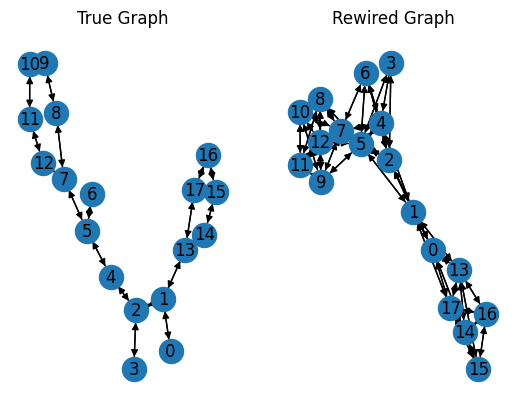

In [34]:
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt
import networkx as nx
from torch_geometric.data import Data

for graph in data_train:


    G1 = to_networkx(Data(edge_index=graph.edge_index, num_nodes=graph.x.shape[0]))
    G2 = to_networkx(Data(edge_index=graph.new_edge_index, num_nodes=graph.x.shape[0]))

    fig, (ax1, ax2) = plt.subplots(1, 2)

    # plot the first graph on the first column
    nx.draw(G1, ax=ax1, with_labels=True)
    ax1.set_title("True Graph")

    # plot the second graph on the second column
    nx.draw(G2, ax=ax2, with_labels=True)
    ax2.set_title("Rewired Graph")

    plt.show()
    # plt.show()
